11주 반기/년월별
강의자료의 문제: 서울시 열린데이터광장의 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 읽어서 데이터프레임으로 만들고 다음을 답하시오.



(1) 전/후반기의 반기별 대여건수 합계, 평균을 출력

(2) 년월별 대여건수를 계산하고 선그래프 출력

    - y축 대여건수

    - x축 년월별 (2018년 1월, 2월, ... , 12월, 2019년 1월, ... 이런 순서)

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2f72c73d9e29a3f38fc2ab60b7f610abbfea7643f4bac8db253996785881529a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
from pyspark.sql.functions import *
import os, sys
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [8]:
_bicycle = spark.read.format('csv')\
    .options(header='true', inferschema='true').load('/content/drive/MyDrive/seoulBicycleDailyCount_2018_201903.csv')

In [9]:
_bicycle.printSchema()

root
 |-- date: date (nullable = true)
 |--  count: integer (nullable = true)



In [12]:
bicycle=_bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")

In [15]:
bicycle

DataFrame[Date: date, Count: int, year: int, month: int]

In [14]:
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

In [19]:
bicycle.show()

+----------+-----+----+-----+----------+
|      Date|Count|year|month|year_month|
+----------+-----+----+-----+----------+
|2018-01-01| 4950|2018|    1|    2018-1|
|2018-01-02| 7136|2018|    1|    2018-1|
|2018-01-03| 7156|2018|    1|    2018-1|
|2018-01-04| 7102|2018|    1|    2018-1|
|2018-01-05| 7705|2018|    1|    2018-1|
|2018-01-06| 5681|2018|    1|    2018-1|
|2018-01-07| 5220|2018|    1|    2018-1|
|2018-01-08| 6309|2018|    1|    2018-1|
|2018-01-09| 5988|2018|    1|    2018-1|
|2018-01-10| 4476|2018|    1|    2018-1|
|2018-01-11| 4337|2018|    1|    2018-1|
|2018-01-12| 4401|2018|    1|    2018-1|
|2018-01-13| 3756|2018|    1|    2018-1|
|2018-01-14| 4675|2018|    1|    2018-1|
|2018-01-15| 6993|2018|    1|    2018-1|
|2018-01-16| 7421|2018|    1|    2018-1|
|2018-01-17| 6990|2018|    1|    2018-1|
|2018-01-18| 7054|2018|    1|    2018-1|
|2018-01-19| 8329|2018|    1|    2018-1|
|2018-01-20| 6148|2018|    1|    2018-1|
+----------+-----+----+-----+----------+
only showing top

In [18]:
bicycle = bicycle.withColumn('year_month', F.concat(F.col('year'),F.lit('-'),F.col('month')))

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


def classifyQuarter(s):
    q=""
    s=int(s)
    if 1<=s and s<= 6:
        q="전반기"
    elif 7<=s and s<=12:
        q="후반기"
    else:
        q="no"
    return q

quarter_udf = udf(classifyQuarter, StringType())

In [21]:
bicycle=bicycle.withColumn("quarter", quarter_udf(bicycle.month))

In [23]:
bicycle.groupBy('quarter').count().show()

+-------+-----+
|quarter|count|
+-------+-----+
| 후반기|  184|
| 전반기|  271|
+-------+-----+



#대여건수 합계

In [24]:
bicycle.groupBy('year').pivot('quarter').agg({"count":"sum"}).show()

+----+-------+-------+
|year| 전반기| 후반기|
+----+-------+-------+
|2018|3656386|6468488|
|2019|1871935|   NULL|
+----+-------+-------+



#대여건수 평균

In [25]:
bicycle.groupBy('year').pivot('quarter').agg({"count":"avg"}).show()

+----+------------------+-----------------+
|year|            전반기|           후반기|
+----+------------------+-----------------+
|2018|20201.027624309394|35154.82608695652|
|2019|20799.277777777777|             NULL|
+----+------------------+-----------------+



#pandas 시각화 하기

In [26]:
import pandas as pd
import numpy as np
bicycleP = bicycle.toPandas()

#판다스 활용 대여건수 합계

In [28]:
pd.pivot_table(bicycleP, values = 'Count', index = ['year'], columns = ['quarter'], aggfunc= 'sum')

quarter,전반기,후반기
year,,
2018,3656386.0,6468488.0
2019,1871935.0,NaN


#판다스 활용 대여건수 평균

In [29]:
pd.pivot_table(bicycleP, values = 'Count', index = ['year'], columns = ['quarter'], aggfunc=np.mean)

quarter,전반기,후반기
year,,
2018,20201.027624,35154.826087
2019,20799.277778,NaN


In [30]:
sumMonthly=bicycle.groupBy('year_month','year','month').agg({"count":"sum"})

In [31]:
sumMonthly

DataFrame[year_month: string, year: int, month: int, sum(count): bigint]

In [32]:
sumMonthly.show()

+----------+----+-----+----------+
|year_month|year|month|sum(count)|
+----------+----+-----+----------+
|    2018-5|2018|    5|    965609|
|    2018-7|2018|    7|   1100015|
|   2018-11|2018|   11|    961532|
|    2018-1|2018|    1|    164367|
|    2018-2|2018|    2|    168741|
|    2018-4|2018|    4|    687885|
|    2018-9|2018|    9|   1447993|
|    2018-6|2018|    6|   1207123|
|    2019-3|2019|    3|    904819|
|    2018-8|2018|    8|   1037505|
|   2018-12|2018|   12|    500822|
|    2019-2|2019|    2|    471543|
|   2018-10|2018|   10|   1420621|
|    2018-3|2018|    3|    462661|
|    2019-1|2019|    1|    495573|
+----------+----+-----+----------+



In [33]:
pdf=sumMonthly.toPandas()
pdf=pdf.sort_values(['year','month'],ascending=True)

In [34]:
pdf

,year_month,year,month,sum(count)
3,2018-1,2018,1,164367
4,2018-2,2018,2,168741
13,2018-3,2018,3,462661
5,2018-4,2018,4,687885
0,2018-5,2018,5,965609
7,2018-6,2018,6,1207123
1,2018-7,2018,7,1100015
9,2018-8,2018,8,1037505
6,2018-9,2018,9,1447993
12,2018-10,2018,10,1420621


In [35]:
my=pdf.drop('year', 1)
my=my.drop('month', 1)

<ipython-input-35-dbff5a6cb639>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  my=pdf.drop('year', 1)
<ipython-input-35-dbff5a6cb639>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  my=my.drop('month', 1)


In [36]:
my

,year_month,sum(count)
3,2018-1,164367
4,2018-2,168741
13,2018-3,462661
5,2018-4,687885
0,2018-5,965609
7,2018-6,1207123
1,2018-7,1100015
9,2018-8,1037505
6,2018-9,1447993
12,2018-10,1420621


In [37]:
my = my.reset_index()

In [38]:
my

,index,year_month,sum(count)
0,3,2018-1,164367
1,4,2018-2,168741
2,13,2018-3,462661
3,5,2018-4,687885
4,0,2018-5,965609
5,7,2018-6,1207123
6,1,2018-7,1100015
7,9,2018-8,1037505
8,6,2018-9,1447993
9,12,2018-10,1420621


In [39]:
my=my.drop('index', 1)

<ipython-input-39-4a42d25d3838>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  my=my.drop('index', 1)


In [40]:
my

,year_month,sum(count)
0,2018-1,164367
1,2018-2,168741
2,2018-3,462661
3,2018-4,687885
4,2018-5,965609
5,2018-6,1207123
6,2018-7,1100015
7,2018-8,1037505
8,2018-9,1447993
9,2018-10,1420621


<Axes: title={'center': 'Number of rentals by year and month'}, xlabel='year_month', ylabel='Number of rentals'>

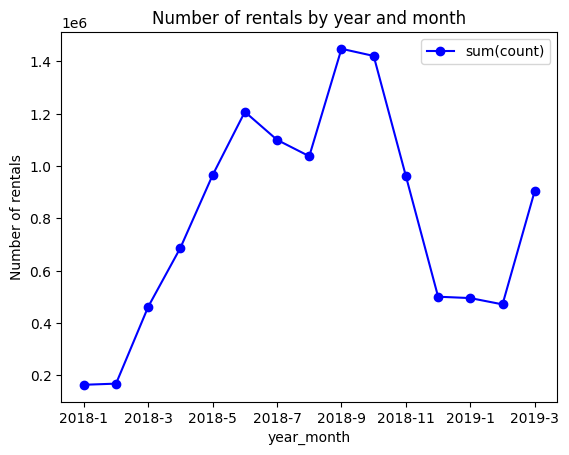

In [49]:
my.plot(x = 'year_month',y = 'sum(count)', linestyle='-',
        marker='o',
        color='blue',
        ylabel = 'Number of rentals',
        title ="Number of rentals by year and month"
        )

